<a href="https://colab.research.google.com/github/AYA-NASH/NN_with_TensorFlow/blob/main/9_Milestone_Project_2_Skimlit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Import Modules:


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn 
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer  # turns text data into numbers using TF_IDF
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

import tensorflow as tf
from tensorflow.keras.layers  import TextVectorization, Embedding, Input, Conv1D, GlobalMaxPooling1D ,GlobalAveragePooling1D, Bidirectional,LSTM ,Dense
from tensorflow.keras import Model
import tensorflow_hub as hub


###Getting the Data:


In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 6.58 MiB/s, done.
Updating files: 100% (13/13), done.


In [ ]:
!ls pubmed-rct

PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
# see all of the file names in target directory

file_names = [data_dir + file_name for file_name in os.listdir(data_dir)]

file_names

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

###Preprocessing the pubMed data

In [ ]:
def get_lines(file_name):
  with open(file_name,'r') as f:
    return f.readlines()      

In [ ]:
train_lines = get_lines(data_dir + "train.txt")

In [ ]:
train_lines[:10]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
"""
  The target output (each line will be a dictionary):
  [
    {line_number : 0,
    target: BACKGROUND,
    text: "--------",
    total_lines: },
    {

    },
    .......
  ]
"""


def preprocess_text_with_line_numbers(filename):

  # get data_lines as a list
  data = get_lines(filename)

  # each abstract starts with an ID (###----) and ends with '\n'
  # using the abstract's start and end will help us to take each abstract separatly 
  # and loop through it as lines and converting them to our targt dictionary(to build the list of dictionaries)
  list_of_dics = []
  abstract_lines = '' # to accumulate all of the abstract lines between the ID and ending space


  for line in data:

    if line.startswith("###"):  # if it was an id reset the abstract_lines to empty string
      abstract_lines= ""

    elif line.isspace(): # note: '\n' is read as a space
      # we reached the end of the abstract, so split it into lines
      abstract_lines_split = abstract_lines.splitlines()

      # loop through these splitted lines to build our dictionary
      
      for abstract_line_number, abstract_line in enumerate(abstract_lines_split):
        abstract_line_dic = {}
        
        s = abstract_line.split('\t')

        abstract_line_dic['target'] = s[0]
        abstract_line_dic['text'] = s[1].lower()
        abstract_line_dic['line_number'] = abstract_line_number
        abstract_line_dic['total_lines'] = len(abstract_lines_split)-1
        list_of_dics.append(abstract_line_dic)

    else:
      abstract_lines += line

  return list_of_dics

In [ ]:
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
dev_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
# Make sure to load the local version of the test.txt first!!!!!!
test_samples = preprocess_text_with_line_numbers(data_dir +"test.txt")

###Visualizing our Data

Convert the data sentences into DataFrame to be more readable

In [ ]:
train_df = pd.DataFrame(train_samples)
test_df = pd.DataFrame(test_samples)
dev_df = pd.DataFrame(dev_samples)

train_df.head(15)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
# Count targets to make sure that our data is balanced
train_df['target'].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<Axes: ylabel='Frequency'>

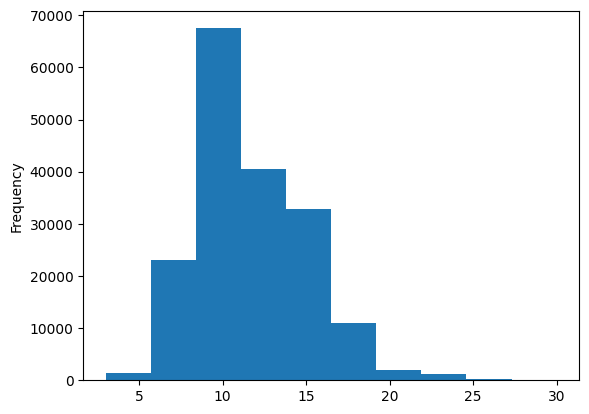

In [ ]:
# Visualize the distribution of number of lines per each abstract:
train_df.total_lines.plot.hist()

In [ ]:
# turn all data to lists to convert them later to numric representation:
train_sentences = train_df['text'].tolist()
dev_sentences =  dev_df['text'].tolist()
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

###Convert sentences into their numeric representations

we will convert our targets to both as numbers and as one-hot encoded vectors

In [ ]:
# convert to one-hot vectors

# Using Sklearn:
# The input to this transformer should be an array-like of integers
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
dev_labels_one_hot = one_hot_encoder.transform(dev_df['target'].to_numpy().reshape(-1,1))


In [ ]:
print(train_labels_one_hot.shape)
# print(test_labels_one_hot.shape)
print(dev_labels_one_hot.shape)

(180040, 5)
(30212, 5)


In [ ]:
train_labels = train_df['target'].to_numpy()
dev_labels = dev_df['target'].to_numpy()

dev_labels[:10]

array(['BACKGROUND', 'BACKGROUND', 'OBJECTIVE', 'METHODS', 'METHODS',
       'RESULTS', 'RESULTS', 'RESULTS', 'RESULTS', 'CONCLUSIONS'],
      dtype=object)

###Converting Text sentences into numbers

####word_level preparation:

**Tokenization Step :**
converting text data into numbers(i.e. indicies)

np.percentile :to know what length of sentences that covers 50%(some percentage) of our data

In [ ]:
max_features = 68000 # from the paper :(|V| = 68k for the RCT_20k data set)

sent_lens = [len(i.split()) for i in  train_sentences]
# max_len = np.mean(sent_lens)

max_len = round(np.percentile(sent_lens, 95))


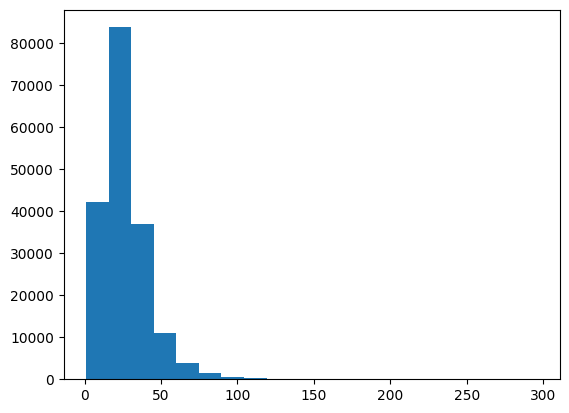

In [ ]:
plt.hist(sent_lens, bins=20);

####char-level preprocessing:

In [ ]:
# making function to split a sentence into characters
def split_chars(sentence):
  return ' '.join(list(sentence))

In [ ]:
sen = 'a test sentence'
split_chars(sen)

'a   t e s t   s e n t e n c e'

In [ ]:
# find the average characters of sequences
chars_len = [len(split_chars(sentence)) for sentence in train_sentences]
# len(train_sentences), len(chars_len), chars_len[:10]
# ex = train_sentences[0]
# len(split_chars(ex))

avg_len = int(np.mean(chars_len))
avg_len

297

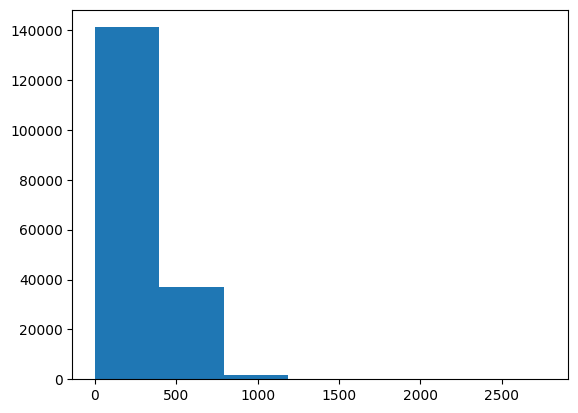

In [ ]:
# check out the distribution of characters:
plt.hist(chars_len, bins=7);
# most common lengths near to 500 characters length

In [ ]:
# or we can use the percentile method:
max_len = round(np.percentile(chars_len, 95))

max_len

579

In [ ]:
# Get all of the characters
import string
alphabet = string.ascii_lowercase +  string.digits + string.punctuation

alphabet, len(alphabet)

('abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~', 68)

**Splitting datastes to characters**

In [ ]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in dev_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


####line_number & total_lines preprocessing (for model_5)

##### Creating positional Embedding 

In [ ]:
train_df

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
...,...,...,...,...
180035,RESULTS,for the absolute change in percent atheroma vo...,7,11
180036,RESULTS,"for pav , a significantly greater percentage o...",8,11
180037,RESULTS,both strategies had acceptable side effect pro...,9,11
180038,CONCLUSIONS,"compared with standard statin monotherapy , th...",10,11


In [ ]:
#  counting the 'line_number' values:
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

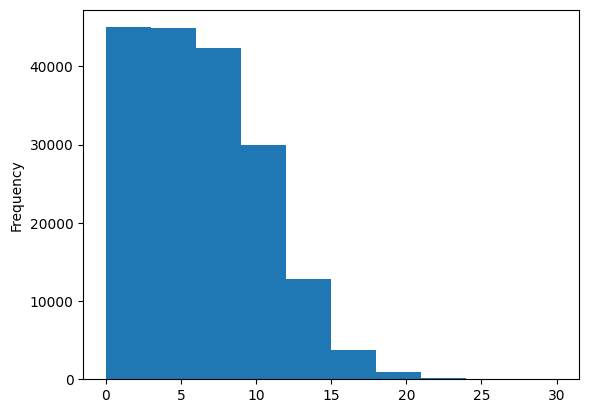

In [ ]:
# Check the distribution of 'line_number' to decide where to cut-off our sequences
train_df.line_number.plot.hist();

# from the output: cutting off at line_number of 15 is more convenient

In [ ]:
# Creating one-hot encoded 'line_number's

train_line_numbers_one_hot = tf.one_hot(train_df['line_number'], depth = 15)
val_line_numbers_one_hot = tf.one_hot(dev_df['line_number'], depth = 15)
train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

In [ ]:
# doing the same steps of 'line_number' to 'total_lines':
train_df['total_lines'].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

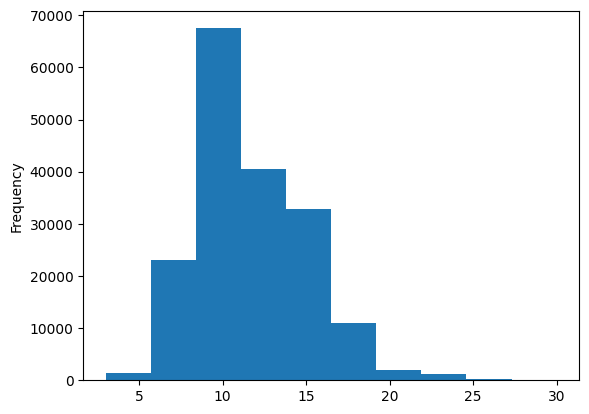

In [ ]:
train_df['total_lines'].plot.hist();

In [ ]:
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'], depth = 20)
val_total_lines_one_hot = tf.one_hot(dev_df['total_lines'], depth = 20)

####Vectorization:

#####Token Vectorization

In [ ]:
token_vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=max_features,
                                                    output_mode='int',
                                                    standardize = 'lower_and_strip_punctuation',
                                                    split='whitespace',
                                                    pad_to_max_tokens=True,
                                                    output_sequence_length=max_len)


In [ ]:
token_vectorize_layer.adapt(train_sentences)

In [ ]:
vocabulary = token_vectorize_layer.get_vocabulary()

# len(vocabulary)
token_vectorize_layer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 579,
 'pad_to_max_tokens': True,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

In [ ]:
embedding = Embedding(input_dim= len(vocabulary),
                      output_dim= 128,
                      mask_zero= True,
                      input_length= max_len)

In [ ]:
x = train_sentences[0]
print(x)
print(token_vectorize_layer([x]))

to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .
tf.Tensor(
[[   6  331    2   79    4   53    4  161 1127  217 2535    5  557   65
  1584    3  670 5559  636    5    2  654 1137    3  180    2   70  495
    36  781   15   53    5  350  266    7  362    6  289  517 1430 1743
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0   

**Embeddings :**
Turns positive integers (indexes) into dense vectors of fixed size.

In [ ]:
embedding(token_vectorize_layer([x]))

<tf.Tensor: shape=(1, 579, 128), dtype=float32, numpy=
array([[[-0.00753624, -0.03465487, -0.03937708, ..., -0.02230535,
         -0.01679326, -0.04212332],
        [-0.02610669, -0.03269448,  0.04673317, ...,  0.02294872,
         -0.01089811,  0.01370892],
        [ 0.0073238 , -0.04035002,  0.02342344, ...,  0.00096168,
          0.03050594, -0.02037603],
        ...,
        [-0.04802377,  0.01555443,  0.00079503, ..., -0.03909501,
         -0.03518086,  0.03298613],
        [-0.04802377,  0.01555443,  0.00079503, ..., -0.03909501,
         -0.03518086,  0.03298613],
        [-0.04802377,  0.01555443,  0.00079503, ..., -0.03909501,
         -0.03518086,  0.03298613]]], dtype=float32)>

#####Char-level Vectorization

In [ ]:
NUM_CHAR_TOKENS = len(alphabet)+2

character_vectorizer = tf.keras.layers.TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                                    pad_to_max_tokens=True,
                                                    output_sequence_length=max_len)

In [ ]:
character_vectorizer.adapt(train_chars)

In [ ]:
# Check character vocabulary characteristics
char_vocab = character_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [ ]:
# Test out character vectorizer
import random
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = character_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
t h e r e   i s   a   n e e d   f o r   f u r t h e r   r e s e a r c h   t h a t   f o c u s e s   o n   c o m p l e x   p t s d   p a t i e n t s   .

Length of chars: 63

Vectorized chars:
[[ 3 13  2  8  2  4  9  5  6  2  2 10 17  7  8 17 16  8  3 13  2  8  8  2
   9  2  5  8 11 13  3 13  5  3 17  7 11 16  9  2  9  7  6 11  7 15 14 12
   2 24 14  3  9 10 14  5  3  4  2  6  3  9  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

#####char-level Embeddings

In [ ]:
char_embed = Embedding(input_dim=NUM_CHAR_TOKENS,
                        output_dim = 25,
                        mask_zero = True,
                        input_length = max_len)


In [ ]:
char_embed(vectorized_chars)

<tf.Tensor: shape=(1, 579, 25), dtype=float32, numpy=
array([[[-0.04114729,  0.03102516,  0.04915329, ..., -0.02493883,
         -0.01545296,  0.04295114],
        [-0.03421345, -0.04681305, -0.03828435, ...,  0.03540212,
          0.02701631,  0.03783305],
        [ 0.03949436, -0.02037017, -0.0397666 , ..., -0.04919834,
         -0.01332001, -0.01471652],
        ...,
        [ 0.04239077,  0.00917398, -0.00724066, ...,  0.0040816 ,
          0.03486599,  0.04048976],
        [ 0.04239077,  0.00917398, -0.00724066, ...,  0.0040816 ,
          0.03486599,  0.04048976],
        [ 0.04239077,  0.00917398, -0.00724066, ...,  0.0040816 ,
          0.03486599,  0.04048976]]], dtype=float32)>

###Creating fast-loading datasets

####Token-level datasets

In [ ]:
# 1- Turn our data into Tensorflow Datasets:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
validation_dataset = tf.data.Dataset.from_tensor_slices((dev_sentences, dev_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset,test_dataset # is a "TensorSliceDataset" object

(<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>,
 <_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>)

In [ ]:
# 2- turn the three TensorSliceDataset object into batches:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

####char-level datasets:

In [ ]:
train_chars_dataset = tf.data.Dataset.from_tensor_slices((train_chars,train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE) 
val_chars_dataset = tf.data.Dataset.from_tensor_slices((val_chars,dev_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_chars_dataset = tf.data.Dataset.from_tensor_slices((test_chars,test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_chars_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

####combine both of token's datasets(e.g. train_dataset) and char datasets (e.g. train_char_dataset) to train(fit) the model_4 

In [ ]:
combined_train_dataset = tf.data.Dataset.from_tensor_slices(((train_sentences, train_chars),train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
combined_val_dataset = tf.data.Dataset.from_tensor_slices(((dev_sentences, val_chars),dev_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
combined_test_dataset = tf.data.Dataset.from_tensor_slices(((test_sentences, test_chars),test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
combined_train_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

####Create tribrid embedding datasets and fit tribrid model:

(token-level,char-level,line_number,total_lines) datasets:

In [ ]:
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices(((train_line_numbers_one_hot,
                                                                 train_total_lines_one_hot,
                                                                 train_sentences,
                                                                 train_chars),
                                                                train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

val_pos_char_token_data = tf.data.Dataset.from_tensor_slices(((val_line_numbers_one_hot,
                                                                 val_total_lines_one_hot,
                                                                 dev_sentences,
                                                                 val_chars),
                                                                dev_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

test_pos_char_token_data = tf.data.Dataset.from_tensor_slices(((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars),
                                                              test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
train_pos_char_token_data

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

###Model_0: baseline model(TF_IDF Multinomial Naive Bayes Classifier)

In [ ]:
# Pipeline is a list of steps
model_0 = Pipeline(
    [
        ("tfidf", TfidfVectorizer()),
        ("clf", MultinomialNB()),
    ]
)

model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
baseline_score = model_0.score(dev_sentences, dev_labels)

baseline_score

0.7218323844829869

###crating a function to evaluate a model with different metrics

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def calculate_results(true_labels, predicted_labels):
  model_accuracy = accuracy_score(true_labels, predicted_labels)
  precision, recall, f_score, _ = precision_recall_fscore_support(true_labels,
                                                                  predicted_labels,
                                                                  average = 'weighted')
  model_results = {"accuracy": model_accuracy*100,
             "precision": precision,
             "recall": recall,
             "f_score": f_score
  }

  return model_results

###Model_1: Conv 1D

In [ ]:
input = Input(shape=(1,), dtype='string')

embedding_layer = embedding(vectorize_layer(input))

x = Conv1D(filters=64,
           kernel_size=5,
           padding = 'same',
           activation='relu')(embedding_layer)

x = GlobalAveragePooling1D()(x)
output = Dense(5, activation='softmax')(x)

model_1 = tf.keras.Model(input, output)

In [ ]:
model_1.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_2 (TextV  (None, 55)               0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 55, 128)           8299648   
                                                                 
 conv1d_3 (Conv1D)           (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d_2   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_13 (Dense)            (None, 5)                 325

In [ ]:
model_1.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
history_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=validation_dataset,
                              validation_steps=int(0.1 * len(validation_dataset))) # only validate on 10% of batches

Epoch 1/3
562/562 [==============================] - 49s 70ms/step - loss: 0.9058 - accuracy: 0.6482 - val_loss: 0.6806 - val_accuracy: 0.7404
Epoch 2/3
562/562 [==============================] - 12s 21ms/step - loss: 0.6562 - accuracy: 0.7566 - val_loss: 0.6302 - val_accuracy: 0.7713
Epoch 3/3
562/562 [==============================] - 10s 17ms/step - loss: 0.6181 - accuracy: 0.7744 - val_loss: 0.5979 - val_accuracy: 0.7826


In [ ]:
# Evaluate model_1 over all dev set
model_1.evaluate(validation_dataset)

945/945 [==============================] - 5s 5ms/step - loss: 0.5996 - accuracy: 0.7854


[0.5996356010437012, 0.7854163646697998]

In [ ]:
# Make predictions (our model outputs prediction probabilities for each class)
model_1_pred_probs = model_1.predict(validation_dataset)
model_1_pred_probs,model_1_pred_probs.shape

945/945 [==============================] - 2s 2ms/step


(array([[4.3047965e-01, 1.3876931e-01, 9.0788282e-02, 3.1745741e-01,
         2.2505360e-02],
        [4.6238822e-01, 2.5171778e-01, 1.5852835e-02, 2.6209325e-01,
         7.9479953e-03],
        [1.4145914e-01, 6.3177925e-03, 1.5033196e-03, 8.5068852e-01,
         3.1228174e-05],
        ...,
        [5.4382772e-06, 5.7767588e-04, 7.7207392e-04, 3.7908383e-06,
         9.9864107e-01],
        [6.0242821e-02, 4.1092154e-01, 1.1837030e-01, 7.3386259e-02,
         3.3707902e-01],
        [1.5972225e-01, 7.1973526e-01, 3.1260531e-02, 3.7926171e-02,
         5.1355746e-02]], dtype=float32),
 (30212, 5))

In [ ]:
#  converting the result predictions into classes (instead of probabilities)
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)

model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
# calculation results:
model_1_results = calculate_results(tf.argmax(dev_labels_one_hot, axis=1), model_1_preds)

In [ ]:
model_1_results

{'accuracy': 78.54163908380775,
 'precision': 0.7820640493739013,
 'recall': 0.7854163908380776,
 'f_score': 0.782864467806752}

###Model_2: pretrained feature extraction model:

In [ ]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embeddings = embed([
    "The quick brown fox jumps over the lazy dog.",
    "I am a sentence for which I would like to get its embedding"])

print(embeddings)

tf.Tensor(
[[-0.03133019 -0.06338634 -0.01607501 ... -0.03242778 -0.04575738
   0.05370455]
 [ 0.05080859 -0.01652433  0.01573778 ...  0.00976659  0.0317012
   0.01788118]], shape=(2, 512), dtype=float32)


In [ ]:
# Downloading the USE (Universal Sentence Encoder) as a layer
hub_embedding_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                     trainable=False,
                                     name="universal_sentence_encoder")

hub_embedding_layer

In [ ]:
# Building model_2
inputs = Input(shape=[], dtype= 'string')

x = hub_embedding_layer(inputs)
# print(embedding_layer.shape)
x = Dense(128, activation='relu')(x)

# print(x.shape)
# x = GlobalAveragePooling1D()(x)
output = Dense(5, activation='softmax')(x)
model_2 = tf.keras.Model(inputs, output)

In [ ]:
model_2.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dense_3 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
history_2 = model_2.fit(train_dataset,
                        steps_per_epoch = (0.1*len(train_dataset)),
                        epochs = 3,
                        validation_data = validation_dataset,
                        validation_steps = (0.1*len(validation_dataset)))

Epoch 1/3
562/562 [==============================] - 12s 15ms/step - loss: 0.9176 - accuracy: 0.6468 - val_loss: 0.8019 - val_accuracy: 0.6836
Epoch 2/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7685 - accuracy: 0.7022 - val_loss: 0.7580 - val_accuracy: 0.7033
Epoch 3/3
562/562 [==============================] - 9s 15ms/step - loss: 0.7506 - accuracy: 0.7131 - val_loss: 0.7391 - val_accuracy: 0.7164


In [ ]:
model_2.evaluate(validation_dataset)

945/945 [==============================] - 11s 12ms/step - loss: 0.7389 - accuracy: 0.7144


[0.7388715744018555, 0.7144181132316589]

In [ ]:
# making predictions:
model_2_pred_probs = model_2.predict(validation_dataset)

model_2_pred_probs

945/945 [==============================] - 11s 11ms/step


array([[4.2791507e-01, 3.6790538e-01, 2.3136232e-03, 1.9303066e-01,
        8.8352729e-03],
       [3.4932935e-01, 4.7597030e-01, 3.7016741e-03, 1.6768141e-01,
        3.3172828e-03],
       [2.4211137e-01, 1.2454263e-01, 1.9555487e-02, 5.7822973e-01,
        3.5560787e-02],
       ...,
       [1.7637211e-03, 5.8988384e-03, 6.6715457e-02, 8.9072448e-04,
        9.2473125e-01],
       [4.3092235e-03, 4.3400344e-02, 2.0696491e-01, 1.5766507e-03,
        7.4374884e-01],
       [1.9398978e-01, 2.3569325e-01, 5.0577313e-01, 7.3659057e-03,
        5.7177931e-02]], dtype=float32)

In [ ]:
model_2_preds = tf.argmax(model_2_pred_probs, axis = 1)
model_2_preds, model_2_preds.shape

(<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>,
 TensorShape([30212]))

In [ ]:
model_2_results = calculate_results(tf.argmax(dev_labels_one_hot, axis = 1), model_2_preds)

model_2_results

{'accuracy': 71.44181120084735,
 'precision': 0.7144852500143697,
 'recall': 0.7144181120084735,
 'f_score': 0.7117964915577542}

###Model_3: Conv1D with character-level tokenization

####Building the character-level Conv1D model:

In [ ]:
inputs = Input(shape=(1,), dtype='string')

x = character_vectorizer(inputs)
x = char_embed(x)

x = Conv1D(filters=64,
           kernel_size=5,
           padding = 'same',
           activation='relu')(x)

# x = GlobalAveragePooling1D()(x)
x = GlobalMaxPooling1D()(x)
output = Dense(5, activation='softmax')(x)

model_3 = tf.keras.Model(inputs, output)

In [ ]:
model_3.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 579)              0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 579, 25)           1750      
                                                                 
 conv1d (Conv1D)             (None, 579, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_1 (Dense)             (None, 5)                 325 

In [ ]:
model_3.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
history_3 = model_3.fit(train_chars_dataset,
                        steps_per_epoch = (0.1*len(train_chars_dataset)),
                        epochs = 3,
                        validation_data = val_chars_dataset,
                        validation_steps = (0.1*len(val_chars_dataset)))

Epoch 1/3
562/562 [==============================] - 14s 9ms/step - loss: 1.2458 - accuracy: 0.4984 - val_loss: 1.0340 - val_accuracy: 0.5911
Epoch 2/3
562/562 [==============================] - 3s 6ms/step - loss: 0.9968 - accuracy: 0.5986 - val_loss: 0.9407 - val_accuracy: 0.6299
Epoch 3/3
562/562 [==============================] - 4s 7ms/step - loss: 0.9269 - accuracy: 0.6342 - val_loss: 0.8761 - val_accuracy: 0.6530


In [ ]:
model_3.evaluate(val_chars_dataset)

945/945 [==============================] - 8s 8ms/step - loss: 0.8913 - accuracy: 0.6510


[0.8913211226463318, 0.6509996056556702]

In [ ]:
model_3_pred_probs = model_3.predict(val_chars_dataset)

model_3_pred_probs[:10]

945/945 [==============================] - 5s 5ms/step


array([[1.7325251e-01, 3.1804803e-01, 2.3344275e-01, 2.4223033e-01,
        3.3026394e-02],
       [1.4178784e-01, 5.2231139e-01, 6.2089483e-03, 2.8432059e-01,
        4.5371257e-02],
       [2.8280672e-02, 7.0590183e-02, 6.8816346e-01, 1.2429140e-01,
        8.8674299e-02],
       [8.0970451e-03, 1.4606726e-02, 9.1021037e-01, 1.8613784e-02,
        4.8471976e-02],
       [3.5951700e-02, 7.6598741e-02, 6.9371378e-01, 5.8666147e-02,
        1.3506953e-01],
       [5.9351081e-04, 7.4976380e-04, 8.1529695e-01, 8.8432687e-04,
        1.8247549e-01],
       [2.2450138e-03, 6.6680443e-03, 7.7425176e-01, 1.0480526e-03,
        2.1578719e-01],
       [3.0003783e-01, 4.1603357e-01, 3.0374046e-02, 2.0301780e-01,
        5.0536785e-02],
       [3.6280090e-03, 1.2655819e-02, 1.5060975e-01, 9.5094778e-03,
        8.2359701e-01],
       [9.2487849e-02, 2.8274849e-01, 3.5743374e-01, 1.6708557e-01,
        1.0024437e-01]], dtype=float32)

In [ ]:
model_3_preds = tf.argmax(model_3_pred_probs, axis = 1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 2, ..., 4, 4, 0])>

In [ ]:
model_3_results = calculate_results(tf.argmax(dev_labels_one_hot, axis = 1), model_3_preds)

model_3_results

{'accuracy': 65.09996028068316,
 'precision': 0.6453087680809645,
 'recall': 0.6509996028068317,
 'f_score': 0.6356082856300015}

###Model_4:  Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

passing the character-level embeddings to bi-LSTM model and concatenate the result with the token-embedding (replicating the paper)

In [ ]:
# 1- construct the token-embedding part (with pre-trained USE model):
token_input = Input(shape=[], dtype='string')
token_embeddings = hub_embedding_layer(token_input)
token_output = Dense(128,activation='relu')(token_embeddings)
token_model = Model(token_input, token_output)

# 2- construct the character-level part with bi_LSTM
char_input = Input(shape=(1,), dtype='string')
char_embeddings = char_embed(character_vectorizer(char_input))
bi_lstm = Bidirectional(LSTM(24))(char_embeddings)
char_model = Model(char_input, bi_lstm)

# 3- Concatenate the output of both models:
embedding_concat = tf.keras.layers.Concatenate()([token_model.output, char_model.output])

# 4- building more layers above the concatenated result
combined_dropout = tf.keras.layers.Dropout(0.5)(embedding_concat)
combined_dense = Dense(200, activation='relu')(combined_dropout)
final_dropout = tf.keras.layers.Dropout(0.5)(combined_dense)

final_output = Dense(5, activation='softmax')(final_dropout)

# 5- combine multi-inputs with the final output
model_4 = Model(inputs=[token_model.input, char_model.input], outputs= final_output)

In [ ]:
model_4.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
model_4.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 text_vectorization_1 (TextVect  (None, 579)         0           ['input_3[0][0]']                
 orization)                                                                                       
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['input_2[0][0]']          

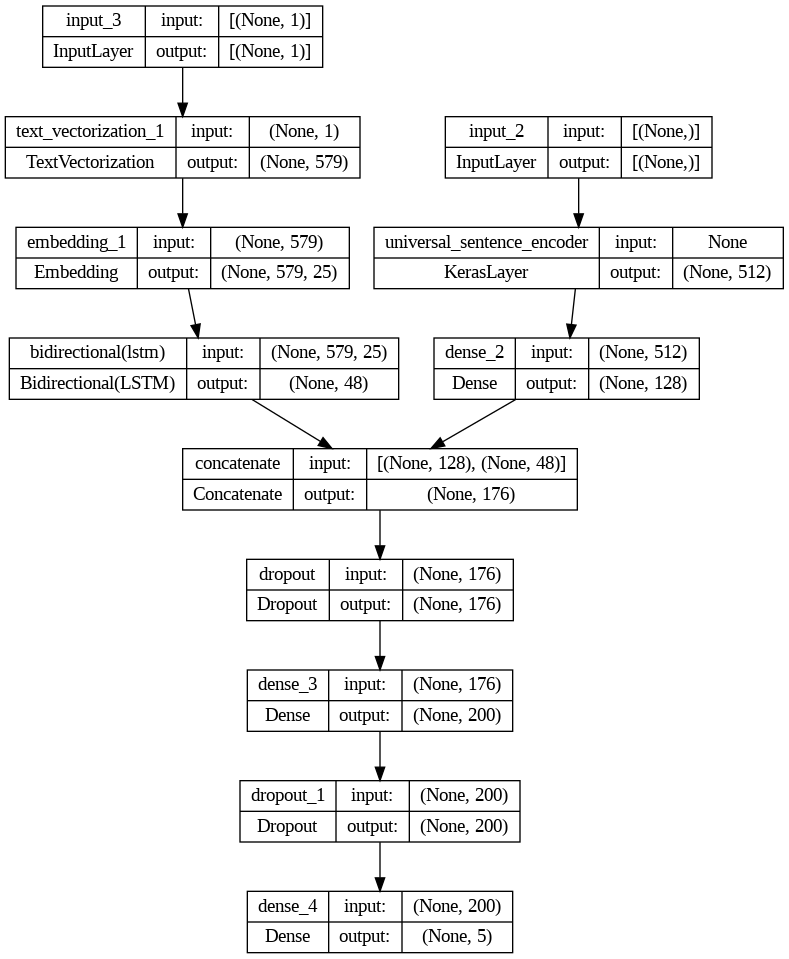

In [ ]:
from keras.utils import plot_model
plot_model(model_4, show_shapes = True)

####Fitting model_4

In [ ]:
history_4 = model_4.fit(combined_train_dataset,
                        steps_per_epoch = (0.1*len(combined_train_dataset)),
                        epochs = 3,
                        validation_data = combined_val_dataset,
                        validation_steps = (0.1*len(combined_val_dataset)))

Epoch 1/3
562/562 [==============================] - 50s 66ms/step - loss: 0.9614 - accuracy: 0.6161 - val_loss: 0.7847 - val_accuracy: 0.6938
Epoch 2/3
562/562 [==============================] - 35s 62ms/step - loss: 0.7910 - accuracy: 0.6912 - val_loss: 0.7191 - val_accuracy: 0.7322
Epoch 3/3
562/562 [==============================] - 29s 51ms/step - loss: 0.7603 - accuracy: 0.7103 - val_loss: 0.6857 - val_accuracy: 0.7414


In [ ]:
model_4.evaluate(combined_val_dataset)

945/945 [==============================] - 21s 22ms/step - loss: 0.6889 - accuracy: 0.7378


[0.6888849139213562, 0.7377532124519348]

In [ ]:
model_4_pred_probs = model_4.predict(combined_val_dataset)

model_4_pred_probs[:10],model_4_pred_probs.shape

945/945 [==============================] - 23s 22ms/step


(array([[4.1974592e-01, 3.3359358e-01, 7.0933523e-03, 2.3430996e-01,
         5.2572726e-03],
        [3.6975795e-01, 4.5548439e-01, 5.0545391e-03, 1.6771269e-01,
         1.9904787e-03],
        [2.3798145e-01, 7.3926307e-02, 5.1699910e-02, 6.1270273e-01,
         2.3689531e-02],
        [1.4390222e-02, 2.2450535e-02, 8.5147065e-01, 8.2004303e-03,
         1.0348812e-01],
        [2.9167509e-02, 9.0387233e-02, 6.4804184e-01, 1.3673669e-02,
         2.1872981e-01],
        [1.4945425e-03, 2.8699760e-03, 7.7908462e-01, 3.4341434e-04,
         2.1620739e-01],
        [3.3348838e-03, 1.5559814e-02, 5.1998705e-01, 9.5394795e-04,
         4.6016431e-01],
        [4.3353117e-03, 3.3005968e-02, 5.4456246e-01, 8.4037852e-04,
         4.1725591e-01],
        [5.8066397e-04, 1.5024274e-02, 4.3812077e-02, 3.0725461e-04,
         9.4027573e-01],
        [2.8503790e-01, 3.9678329e-01, 5.2763868e-02, 2.0771469e-01,
         5.7700276e-02]], dtype=float32),
 (30212, 5))

In [ ]:
model_4_preds = tf.argmax(model_4_pred_probs, axis = 1)

model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [ ]:
model_4_results = calculate_results(tf.argmax(dev_labels_one_hot, axis = 1), model_4_preds)

model_4_results

{'accuracy': 73.7753210644777,
 'precision': 0.7379245337133185,
 'recall': 0.737753210644777,
 'f_score': 0.7356146091279749}

###Model_5:Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

####Building the model with tri-inputs:

similar to model_4, but an additional input is added

In [ ]:
# Downloading the USE (Universal Sentence Encoder) as a layer
hub_embedding_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                     trainable=False,
                                     name="universal_sentence_encoder")

hub_embedding_layer

In [ ]:
# 1- construct the token-embedding part (with pre-trained USE model):
token_input = Input(shape=[], dtype='string', name="token_inputs")
token_embeddings = hub_embedding_layer(token_input)
token_output = Dense(128,activation='relu')(token_embeddings)
token_model = Model(token_input, token_output)

# 2- construct the character-level part with bi_LSTM
char_input = Input(shape=(1,), dtype='string', name="char_inputs")
char_embeddings = char_embed(character_vectorizer(char_input))
bi_lstm = Bidirectional(LSTM(24))(char_embeddings)
char_model = Model(char_input, bi_lstm)


# 3- Constructing The number_line part
line_number_inputs = Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = Dense(32, activation='relu')(line_number_inputs)
line_number_model = Model(inputs=line_number_inputs,
                          outputs= x)

# 4- total_lines part:
total_lines_inputs = Input(shape=(20,), dtype= tf.int32, name="total_lines_input")
y = Dense(32, activation='relu')(total_lines_inputs)
total_lines_model = Model(inputs= total_lines_inputs,
                          outputs = y)

# 5- Concatenate the output of token-embedding with char-embedding:
embedding_concat = tf.keras.layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output,
                                                                                    char_model.output])
z = Dense(256, activation='relu')(embedding_concat)
z = tf.keras.layers.Dropout(0.5)(z)

# 6- Concatenat the line-number model ,and total-lines model with the combined embedding-concat model
z = tf.keras.layers.Concatenate(name='token_char_positional_embedding')([line_number_model.output,
                                                                         total_lines_model.output,
                                                                         z])

# 7- the output layer
output_layer = Dense(5, activation='softmax')(z)

# 8- combine multi-inputs with the final output
model_5 = Model(inputs=[line_number_model.input,
                        total_lines_model.input,
                        token_model.input,
                        char_model.input], 
                outputs= output_layer)

In [ ]:
model_5.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 text_vectorization_1 (TextVect  (None, 579)         0           ['char_inputs[0][0]']            
 orization)                                                                                       
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']     

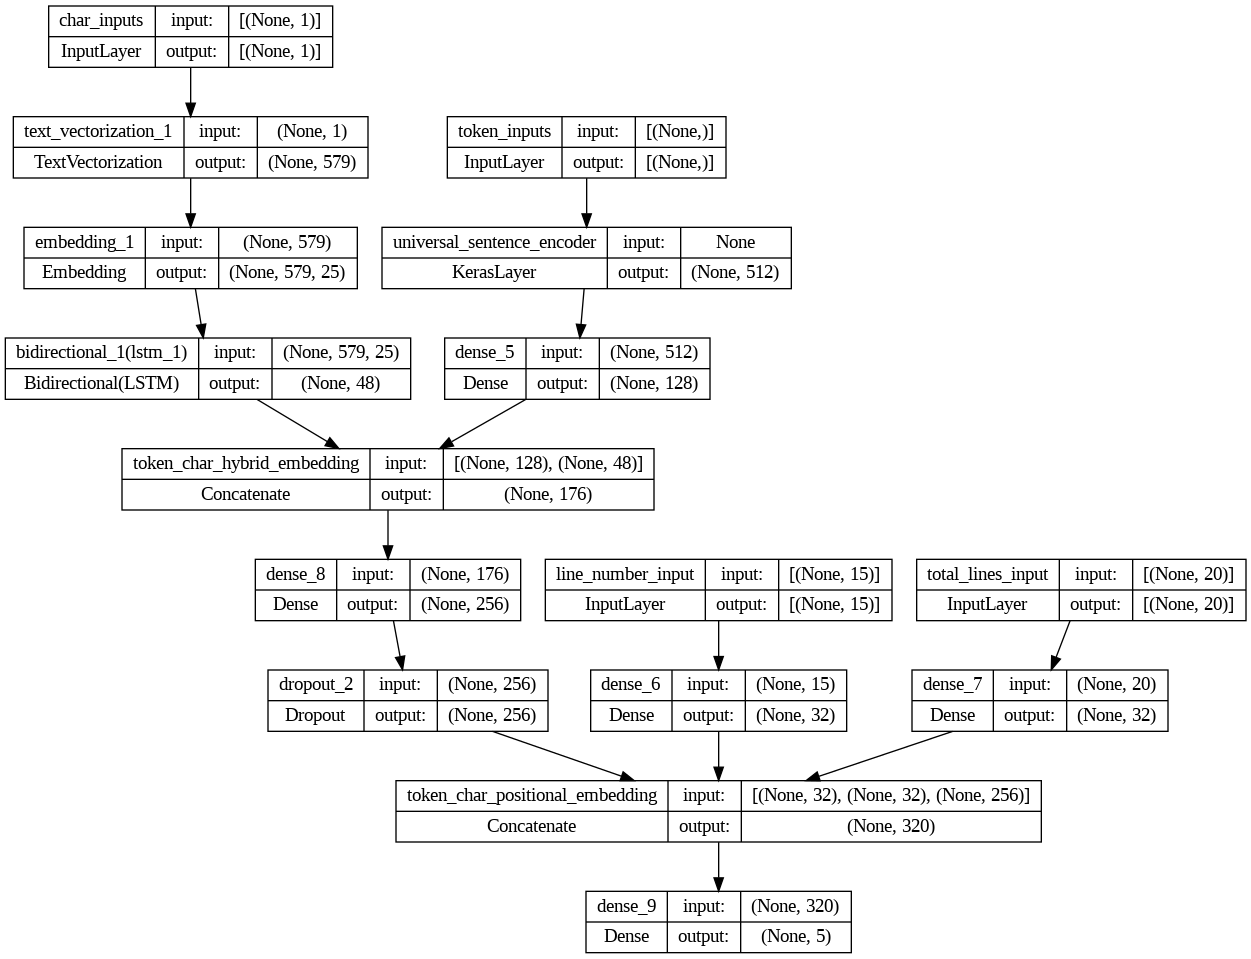

In [ ]:
from keras.utils import plot_model
plot_model(model_5, show_shapes=True)

####Compile the model by using 'Label Smoothing' wiht the categorical crossentropy loss function

In [ ]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

####Fitting the model

In [ ]:
history_5 = model_5.fit(train_pos_char_token_data,
                        steps_per_epoch = (0.1*len(train_pos_char_token_data)),
                        epochs = 3,
                        validation_data = val_pos_char_token_data,
                        validation_steps = (0.1*len(val_pos_char_token_data)))

Epoch 1/3
562/562 [==============================] - 56s 68ms/step - loss: 1.0940 - accuracy: 0.7251 - val_loss: 0.9863 - val_accuracy: 0.7984
Epoch 2/3
562/562 [==============================] - 38s 68ms/step - loss: 0.9674 - accuracy: 0.8156 - val_loss: 0.9519 - val_accuracy: 0.8201
Epoch 3/3
562/562 [==============================] - 28s 51ms/step - loss: 0.9501 - accuracy: 0.8208 - val_loss: 0.9376 - val_accuracy: 0.8332


In [ ]:
model_5.evaluate(val_pos_char_token_data)

945/945 [==============================] - 22s 23ms/step - loss: 0.9386 - accuracy: 0.8310


[0.9385805130004883, 0.8310273885726929]

In [ ]:
model_5_pred_probs = model_5.predict(val_pos_char_token_data)

model_5_pred_probs.shape

945/945 [==============================] - 23s 22ms/step


(30212, 5)

In [ ]:
model_5_probs = tf.argmax(model_5_pred_probs, axis = 1)

model_5_probs.shape

TensorShape([30212])

In [ ]:
model_5_results = calculate_results(tf.argmax(dev_labels_one_hot, axis=1),
                                    model_5_probs)

model_5_results

{'accuracy': 83.10274063286111,
 'precision': 0.8297816779953909,
 'recall': 0.8310274063286112,
 'f_score': 0.8301594814087869}

###Comparing The performance of all Experiments:

In [ ]:
baseline_preds = model_0.predict(dev_sentences)
baseline_preds

array(['RESULTS', 'CONCLUSIONS', 'OBJECTIVE', ..., 'RESULTS', 'RESULTS',
       'CONCLUSIONS'], dtype='<U11')

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
baseline_preds_encoded = label_encoder.fit_transform(baseline_preds)

In [ ]:
model_0_results = calculate_results(tf.argmax(dev_labels_one_hot,axis=-1), baseline_preds_encoded)

model_0_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f_score': 0.6989250353450294}

In [ ]:
results_df = pd.DataFrame({"0- Base model":model_0_results,
                          "1- Token-level Conv1D":model_1_results,
                          "2- Pretrained feature extraction":model_2_results,
                          "3- Char-level Conv1D":model_3_results,
                          "4- token+char hybrid model":model_4_results,
                          "5- token+char+positonal embed":model_5_results})

all_model_results = results_df.transpose()

all_model_results

NameError: ignored

In [ ]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

In [ ]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

In [ ]:
# Sort model results by f1-score
all_model_results.sort_values("f_score", ascending=False)["f_score"].plot(kind="bar", figsize=(10, 7));

###Save and load best performing model

In [ ]:
model_5.save("skimlit_tribrid_model")

In [ ]:
!zip -r /content/skimlit_tribrid_model.zip /content/skimlit_tribrid_model

  adding: content/skimlit_tribrid_model/ (stored 0%)
  adding: content/skimlit_tribrid_model/assets/ (stored 0%)
  adding: content/skimlit_tribrid_model/saved_model.pb (deflated 77%)
  adding: content/skimlit_tribrid_model/variables/ (stored 0%)
  adding: content/skimlit_tribrid_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/skimlit_tribrid_model/variables/variables.index (deflated 77%)
  adding: content/skimlit_tribrid_model/keras_metadata.pb (deflated 91%)
  adding: content/skimlit_tribrid_model/fingerprint.pb (stored 0%)


In [ ]:
from google.colab import files
files.download('/content/skimlit_tribrid_model.zip')

FileNotFoundError: ignored

###Using Test set:

In [ ]:
model_5.save("skimlit_tribrid_model")

####turn test data into fast-load datasets

In [ ]:
loaded_model = tf.keras.models.load_model('skimlit_tribrid_model')

In [ ]:
test_samples[1],len(test_samples)

({'target': 'RESULTS',
  'text': 'a post hoc analysis was conducted with the use of data from the evaluation study of congestive heart failure and pulmonary artery catheterization effectiveness ( escape ) .',
  'line_number': 1,
  'total_lines': 8},
 30135)

In [ ]:
test_labels = test_df['target'].to_numpy()
test_labels_one_hot = one_hot_encoder.transform(test_labels.reshape(-1,1))

test_sentences = test_df['text'].tolist()
# test_sentences

In [ ]:
test_chars = [split_chars(sentence) for sentence in test_sentences]
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'], depth = 15)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'], depth = 20)

In [ ]:
# creating anew dataset using test data to evaluate the model on it.
"""
[line_number_model.input,
total_lines_model.input,
token_model.input,
char_model.input]
"""
new_dataset = tf.data.Dataset.from_tensor_slices(((test_line_numbers_one_hot,
                                                   test_total_lines_one_hot,
                                                   test_sentences,
                                                   test_chars)
                                                  ,test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
new_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# making predictions on test dataset
test_pred_probs = loaded_model.predict(new_dataset)

In [ ]:
test_predictions = tf.argmax(test_pred_probs, axis=1)

test_predictions[:10]

In [ ]:
# encoding test labels
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
test_labels_encoded = label_encoder.fit_transform(test_labels)

test_labels_encoded

array([0, 4, 4, ..., 4, 4, 1])

In [ ]:
test_results = calculate_results(test_labels_encoded,
                                 test_predictions)

test_results

###Finding the most wrong predictions:

In [ ]:
predicted_target = label_encoder.inverse_transform(test_predictions)

In [ ]:
predictions_df = pd.DataFrame({"text":test_sentences,
                               "true_label":test_labels,
                               "predicted_label_prob":test_predictions,
                               "predicted_target":predicted_target})

wrong_predictions = predictions_df[predictions_df['true_label'] != predictions_df['predicted_label_prob']].sort_values(by =['predicted_label_prob'] )

In [ ]:
wrong_predictions

In [ ]:
correct =  predictions_df[predictions_df['true_label'] != predictions_df['predicted_label_prob']]

correct

###Make Predictions from the wild

In [ ]:
wild_example = get_lines('example1.txt')

In [ ]:
# Download and open example abstracts (copy and pasted from PubMed)
# import json
# !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

with open("skimlit_example_abstracts.json", "r") as f:
  abstracts = json.load(f)

abstracts

[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

In [ ]:
abstracts[0]['abstract'].split()

In [ ]:
# See what our example abstracts look like
abstracts = pd.DataFrame(abstracts)
abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


In [ ]:
import spacy

def prepare_wild_data(example_abstracts):
  # convert the example into a list of sentences.
  abstract_sentences = []
  nlp = spacy.load("en_core_web_sm")
  doc = nlp(example_abstracts["abstract"])
  assert doc.has_annotation("SENT_START")
  for sent in doc.sents:
      abstract_sentences.append(sent.text)

  # obtain the characters:
  abstract_chars = [split_chars(line) for line in abstract_sentences]

  # getting line_number and total lines:
  abstract_total_lines = len(abstract_sentences)

  # create a list of dictionaries:
  sample_lines = []
  for i, line in enumerate(abstract_sentences):
    dic ={}
    dic['text'] = line
    dic['line_number'] = i
    dic['total_lines'] = abstract_total_lines - 1
    sample_lines.append(dic)

  #  convert all of line_number and total lines into one_hot encoded versions
  all_number_lines= [item ['line_number'] for item in sample_lines]
  abstracat_line_numbers_one_hot = tf.one_hot(all_number_lines, depth=15)

  all_total_lines = [item ['total_lines'] for item in sample_lines]
  abstract_total_lines_one_hot = tf.one_hot(all_total_lines, depth=20)

  return abstracat_line_numbers_one_hot, abstract_total_lines_one_hot, abstract_sentences, abstract_chars

**The test data must be prepared to be in the same format that the model trained on**
so,extract the sentences, chars, line_number, total_lines from the wild_abstarct

In [ ]:
# # Create sentencizer - Source: https://spacy.io/usage/linguistic-features#sbd 
# from spacy.lang.en import English
# nlp = English() # setup English sentence parser
# # sentencizer = nlp.create_pipe("sentencizer") # create sentence splitting pipeline object
# nlp.add_pipe("sentencizer") # add sentence splitting pipeline object to sentence parser
# doc = nlp(example_abstracts[0]["abstract"]) # create "doc" of parsed sequences, change index for a different abstract
# abstract_lines = [str(sent) for sent in list(doc.sents)] # return detected sentences from doc in string type (not spaCy token type)
# abstract_lines

In [ ]:
abstracat_line_numbers_one_hot, abstract_total_lines_one_hot,abstract_sentences,abstract_chars = prepare_wild_data(abstracts[1])

In [ ]:
# Make predictions on sample abstract features
# abstract_sentences and abstract_chars must be tensors
test_abstract_pred_probs= loaded_model.predict(x=(abstracat_line_numbers_one_hot,
                                                  abstract_total_lines_one_hot,
                                                  tf.constant(abstract_sentences),
                                                  tf.constant(abstract_chars)))

1/1 [==============================] - 0s 36ms/step


In [ ]:
test_abstract_pred_probs

array([[0.41475525, 0.02682086, 0.04943504, 0.42142758, 0.08756123],
       [0.49163854, 0.04905115, 0.07514177, 0.31572658, 0.06844188],
       [0.34528905, 0.10771867, 0.2685804 , 0.25067723, 0.02773465],
       [0.10811058, 0.0689583 , 0.6719481 , 0.08375041, 0.06723259],
       [0.2904133 , 0.07943278, 0.45818597, 0.08390862, 0.08805925],
       [0.07489731, 0.09685763, 0.291113  , 0.07628918, 0.4608429 ],
       [0.06386778, 0.12994385, 0.14499824, 0.06336369, 0.5978264 ],
       [0.19465797, 0.2669193 , 0.33032343, 0.08464907, 0.12345026],
       [0.04036812, 0.31066462, 0.17602511, 0.07216004, 0.40078217],
       [0.04107904, 0.3586267 , 0.06679841, 0.04927022, 0.48422566],
       [0.05500566, 0.8372784 , 0.03128814, 0.03927454, 0.0371533 ],
       [0.04104709, 0.6458924 , 0.06504463, 0.04149279, 0.20652312]],
      dtype=float32)

In [ ]:
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds

<tf.Tensor: shape=(12,), dtype=int64, numpy=array([3, 0, 0, 2, 2, 4, 4, 2, 4, 4, 1, 1])>

In [ ]:
# Turn prediction class integers into string class names
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes

['OBJECTIVE',
 'BACKGROUND',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS']

In [ ]:
pd.DataFrame({"text":abstract_sentences,
              "predicted_target":test_abstract_pred_classes})

,text,predicted_target
0,Postpartum depression (PPD) is the most preval...,OBJECTIVE
1,"No single cause of PPD has been identified, ho...",BACKGROUND
2,Three nutritional interventions have drawn par...,BACKGROUND
3,We searched for meta-analyses of randomised co...,METHODS
4,Fish oil:,METHODS
5,Eleven RCT's of prenatal fish oil supplementat...,RESULTS
6,"Vitamin D: no relevant RCT's were identified, ...",RESULTS
7,Diet:,METHODS
8,Two Australian RCT's with dietary advice inter...,RESULTS
9,"With the exception of fish oil, few RCT's with...",RESULTS


In [ ]:
# Visualize abstract lines and predicted sequence labels
for i, line in enumerate(abstract_sentences):
  print(f"{test_abstract_pred_classes[i]}: {line}")

OBJECTIVE: Postpartum depression (PPD) is the most prevalent mood disorder associated with childbirth.
BACKGROUND: No single cause of PPD has been identified, however the increased risk of nutritional deficiencies incurred through the high nutritional requirements of pregnancy may play a role in the pathology of depressive symptoms.
BACKGROUND: Three nutritional interventions have drawn particular interest as possible non-invasive and cost-effective prevention and/or treatment strategies for PPD; omega-3 (n-3) long chain polyunsaturated fatty acids (LCPUFA), vitamin D and overall diet.
METHODS: We searched for meta-analyses of randomised controlled trials (RCT's) of nutritional interventions during the perinatal period with PPD as an outcome, and checked for any trials published subsequently to the meta-analyses.
METHODS: Fish oil:
RESULTS: Eleven RCT's of prenatal fish oil supplementation RCT's show null and positive effects on PPD symptoms.
RESULTS: Vitamin D: no relevant RCT's were 